## Import Libraries

In [1]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.figure as fig
import matplotlib.cm as cm
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
)


from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

import pickle

In [6]:
# Collecting Training and Testing Dataset File Paths

csv_files = os.listdir("./InSDN")
df = pd.DataFrame()

li = []

for filename in csv_files:
    df = pd.read_csv(os.path.join("./InSDN", filename), low_memory=False, index_col=None, header=0)
    li.append(df)
    print("Read in {}".format(filename))

df = pd.concat(li, axis=0, ignore_index=True)
print("Finished reading in {} entire".format(str(df.shape[0])))

Read in metasploitable-2.csv
Read in Normal_data.csv
Read in OVS.csv
Finished reading in 343889 entire


In [7]:
df.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.3.130-200.175.2.130-38694-4444-6,192.168.3.130,38694,200.175.2.130,4444,6,10/1/2020 5:02,269709,4,5,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,U2R
1,192.168.3.130-200.175.2.130-38693-4444-6,192.168.3.130,38693,200.175.2.130,4444,6,10/1/2020 5:02,268599,2,3,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,U2R
2,192.168.3.130-200.175.2.130-3632-33747-6,200.175.2.130,33747,192.168.3.130,3632,6,10/1/2020 5:02,22194,5,5,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,U2R
3,192.168.3.130-200.175.2.130-8180-38745-6,200.175.2.130,38745,192.168.3.130,8180,6,10/1/2020 1:39,9556,4,4,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BFA
4,192.168.3.130-200.175.2.130-8180-37217-6,200.175.2.130,37217,192.168.3.130,8180,6,10/1/2020 1:39,8782,4,4,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BFA


In [8]:
df.shape

(343889, 84)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343889 entries, 0 to 343888
Data columns (total 84 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Flow ID            343889 non-null  object 
 1   Src IP             343889 non-null  object 
 2   Src Port           343889 non-null  int64  
 3   Dst IP             343889 non-null  object 
 4   Dst Port           343889 non-null  int64  
 5   Protocol           343889 non-null  int64  
 6   Timestamp          343889 non-null  object 
 7   Flow Duration      343889 non-null  int64  
 8   Tot Fwd Pkts       343889 non-null  int64  
 9   Tot Bwd Pkts       343889 non-null  int64  
 10  TotLen Fwd Pkts    343889 non-null  float64
 11  TotLen Bwd Pkts    343889 non-null  float64
 12  Fwd Pkt Len Max    343889 non-null  int64  
 13  Fwd Pkt Len Min    343889 non-null  int64  
 14  Fwd Pkt Len Mean   343889 non-null  float64
 15  Fwd Pkt Len Std    343889 non-null  float64
 16  Bw

In [10]:
df.describe()

,Src Port,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,343889.000000,343889.000000,343889.000000,3.438890e+05,343889.000000,343889.000000,3.438890e+05,3.438890e+05,343889.000000,343889.000000,...,343889.000000,343889.0,3.438890e+05,3.438890e+05,3.438890e+05,3.438890e+05,3.438890e+05,3.438890e+05,3.438890e+05,3.438890e+05
mean,21982.659541,8072.495366,4.961767,6.737171e+06,6.160331,6.119012,7.310557e+02,8.335005e+03,115.689356,4.447778,...,1.441541,0.0,6.385104e+04,3.105350e+04,1.086384e+05,4.185579e+04,4.708172e+06,1.443613e+05,4.843965e+06,4.581512e+06
std,23669.464108,16275.407358,4.862608,2.183354e+07,1554.168988,105.863392,6.965289e+04,3.429719e+05,666.519811,31.285832,...,39.470056,0.0,7.852718e+05,5.035601e+05,1.220601e+06,6.672299e+05,1.616113e+07,1.653491e+06,1.641612e+07,1.604560e+07
min,0.000000,0.000000,0.000000,-1.540000e+02,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000,0.000000,0.000000,1.700000e+01,0.000000,2.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,443.000000,80.000000,6.000000,2.530000e+03,0.000000,2.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,43920.000000,2495.000000,6.000000,1.208600e+04,2.000000,4.000000,3.000000e+01,3.000000e+01,30.000000,0.000000,...,1.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,65518.000000,65389.000000,17.000000,1.200000e+08,910748.000000,34094.000000,3.160000e+07,1.070000e+08,64239.000000,3900.000000,...,11180.000000,0.0,1.040000e+08,6.830000e+07,1.040000e+08,1.040000e+08,1.200000e+08,7.300000e+07,1.200000e+08,1.200000e+08


## Data Preprocessing

In [11]:
# Check the target distribution of the training data
df["Label"].value_counts()

Label
Probe         98129
DDoS          73529
Normal        68424
DoS           53616
DDoS          48413
BFA            1405
Web-Attack      192
BOTNET          164
U2R              17
Name: count, dtype: int64

In [12]:
# Display the columns of the training data
df.columns

Index(['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol',
       'Timestamp', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE 

#### Find the categorical columns, numerical columns, categorical but high cardinality columns.

In [13]:
# Display the columns with only one unique value
for i in df.columns:
    if df[i].nunique() == 1:
        print(i)

Fwd PSH Flags
Fwd URG Flags
CWE Flag Count
ECE Flag Cnt
Fwd Byts/b Avg
Fwd Pkts/b Avg
Fwd Blk Rate Avg
Bwd Byts/b Avg
Bwd Pkts/b Avg
Bwd Blk Rate Avg
Init Fwd Win Byts
Fwd Seg Size Min


In [14]:
# Features with a single unique value
single_val_cols = [col for col in df.columns if df[col].nunique() == 1]

# Remove columns with a single unique value
df.drop(single_val_cols, axis=1, inplace=True)

# Shape of the dataset after removing columns with a single unique value
df.shape

(343889, 72)

In [15]:
def grab_col_names(data, cat_th=10, car_th=20):
    # Categorical columns and categorical but high-cardinality columns
    cat_cols = [col for col in data.columns if data[col].dtypes == "O"]
    num_but_cat = [
        col
        for col in data.columns
        if data[col].nunique() < cat_th and data[col].dtypes != "O"
    ]
    high_card_cat_cols = [
        col
        for col in data.columns
        if data[col].nunique() > car_th and data[col].dtypes == "O"
    ]

    # Combine Object type columns and Low-unique-value numeric columns into cat_cols
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in high_card_cat_cols]

    # Numerical columns excluding those considered as categorical
    num_cols = [col for col in data.columns if data[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # Display information about the dataset
    print(f"Observations: {data.shape[0]}")
    print(f"Variables: {data.shape[1]}")
    print(f"Categorical Columns: {len(cat_cols)}")
    print(f"Numerical Columns: {len(num_cols)}")
    print(f"High Cardinality Categorical Columns: {len(high_card_cat_cols)}")
    print(f"Number but Categorical Columns: {len(num_but_cat)}")
    print("\n")

    return cat_cols, num_cols, high_card_cat_cols


cat_cols, num_cols, high_card_cat_cols = grab_col_names(df)
print(f"Catergorical Columns: {cat_cols}")
print(f"Numerical Columns: {num_cols}")
print(f"High Cardinality Categorical Columns: {high_card_cat_cols}")

Observations: 343889
Variables: 72
Categorical Columns: 10
Numerical Columns: 58
High Cardinality Categorical Columns: 4
Number but Categorical Columns: 9


Catergorical Columns: ['Label', 'Protocol', 'Bwd PSH Flags', 'Bwd URG Flags', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt']
Numerical Columns: ['Src Port', 'Dst Port', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var

In [16]:
# Display the unique values of the categorical columns
for i in cat_cols:
    print(i, df[i].unique())

Label ['U2R' 'BFA' 'DDoS' 'DoS' 'Probe' 'Normal' 'DDoS ' 'Web-Attack' 'BOTNET']
Protocol [ 6 17  0]
Bwd PSH Flags [0 1]
Bwd URG Flags [0 1]
FIN Flag Cnt [0 1]
SYN Flag Cnt [1 0]
RST Flag Cnt [0 1]
PSH Flag Cnt [0 1]
ACK Flag Cnt [0 1]
URG Flag Cnt [0 1]


### Missing Values

In [17]:
# Total number of missing values
print(f"Total number of missing values: {df.isnull().sum().sum()}")

Total number of missing values: 0


### Duplicate Rows

In [18]:
print(f"Number of Duplicate Rows: {df.duplicated().sum()}")

Number of Duplicate Rows: 1


In [19]:
# Remove duplicate rows
df = df.drop_duplicates()

# Exploratory Data Analysis (EDA)


### Categorical Columns

            Label      Ratio
Label                       
Probe       98129  28.535163
DDoS        73529  21.381671
Normal      68423  19.896885
DoS         53616  15.591123
DDoS        48413  14.078130
BFA          1405   0.408563
Web-Attack    192   0.055832
BOTNET        164   0.047690
U2R            17   0.004943




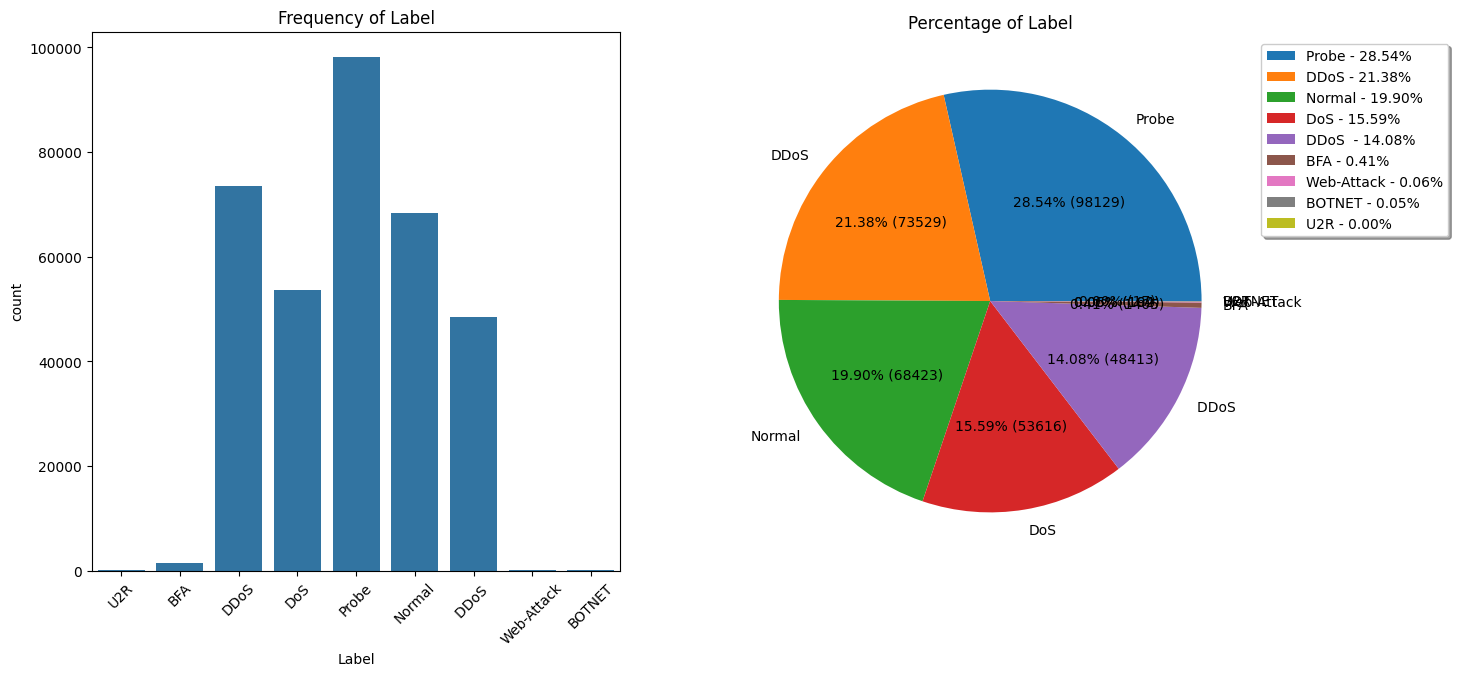

          Protocol      Ratio
Protocol                     
6           188023  54.675650
0           121856  35.434793
17           34009   9.889557




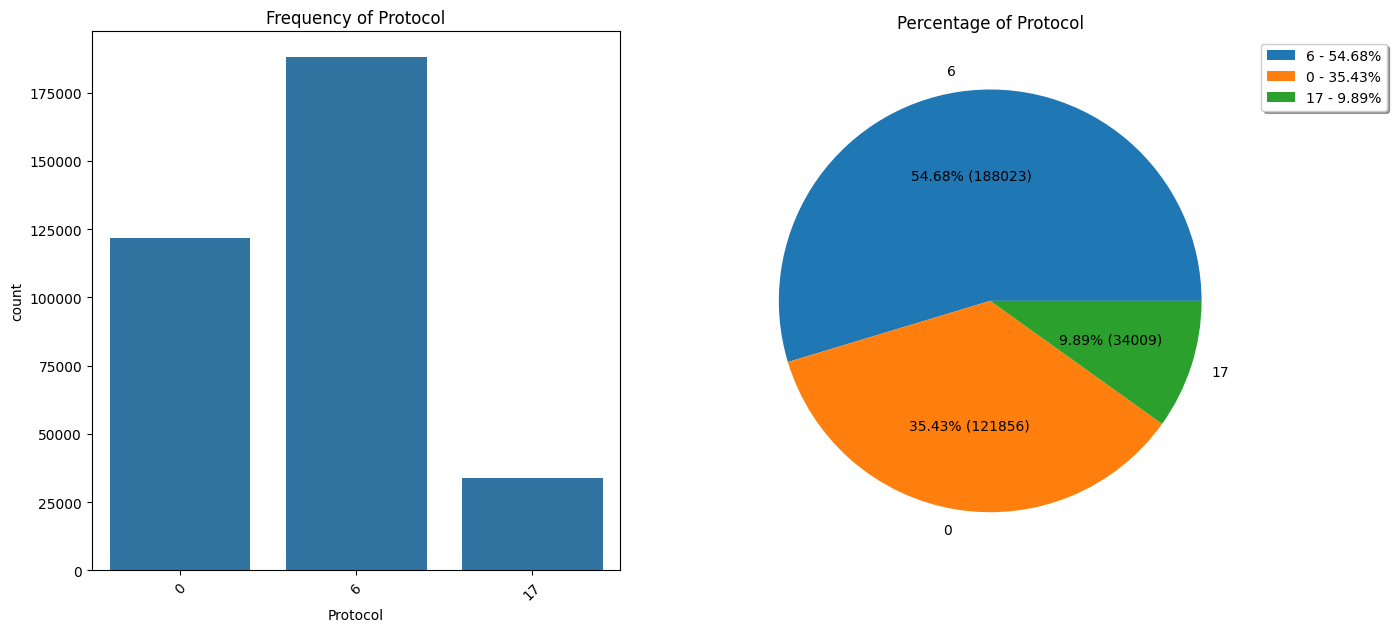

               Bwd PSH Flags      Ratio
Bwd PSH Flags                          
0                     325367  94.614235
1                      18521   5.385765




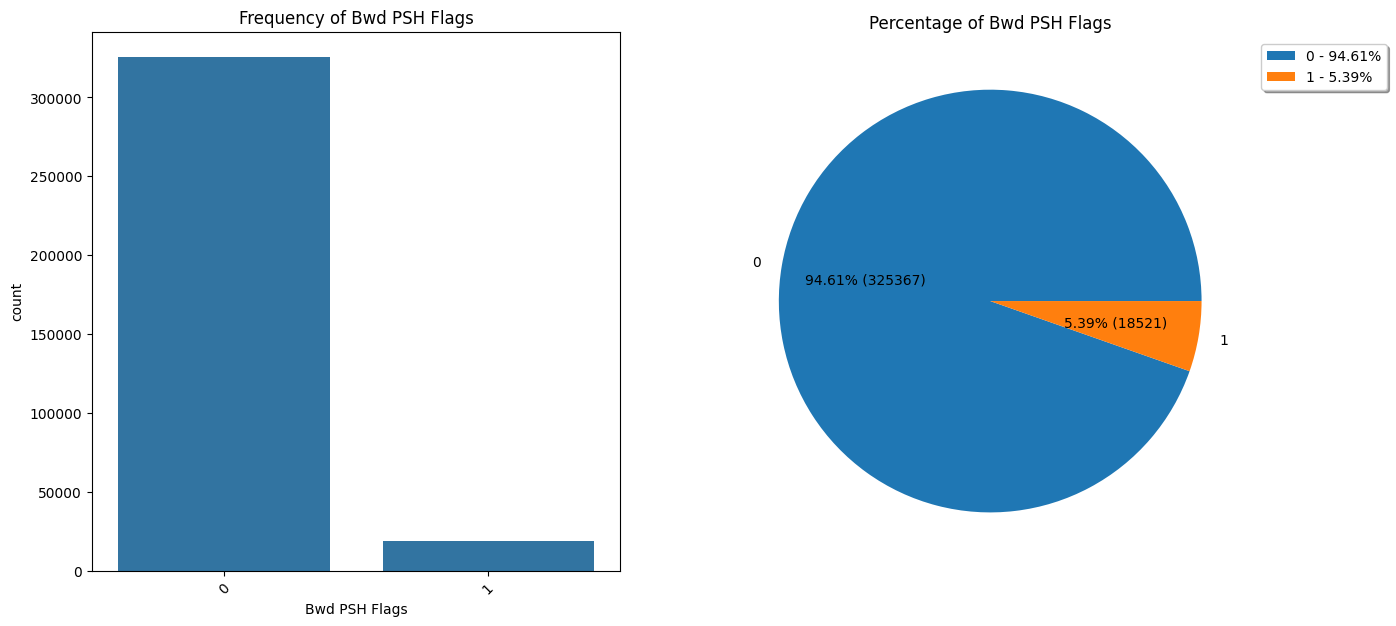

               Bwd URG Flags      Ratio
Bwd URG Flags                          
0                     339889  98.837121
1                       3999   1.162879




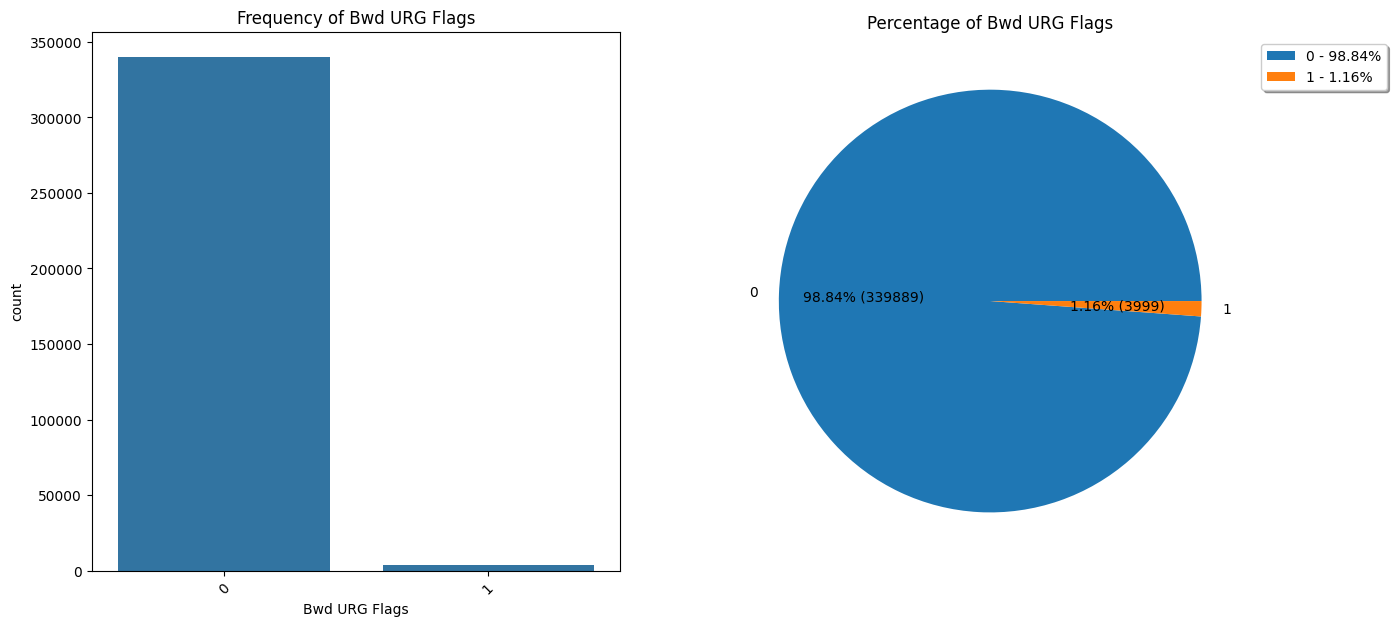

              FIN Flag Cnt      Ratio
FIN Flag Cnt                         
0                   296533  86.229528
1                    47355  13.770472




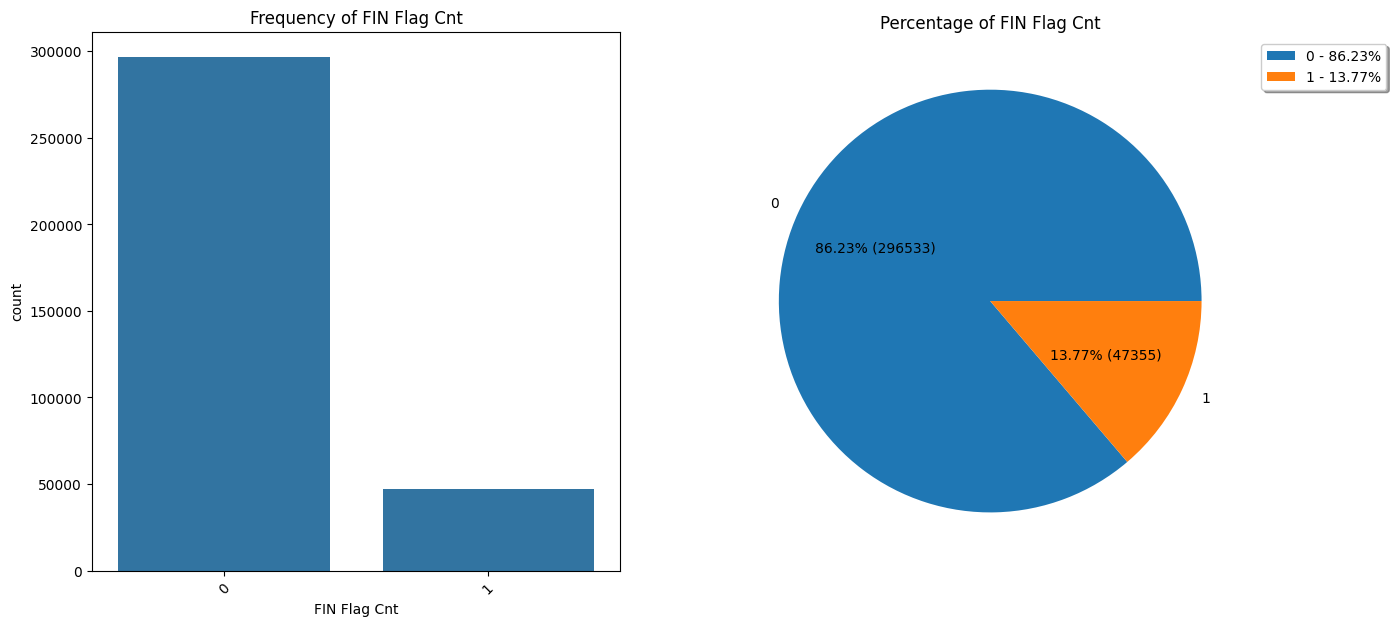

              SYN Flag Cnt      Ratio
SYN Flag Cnt                         
0                   262405  76.305367
1                    81483  23.694633




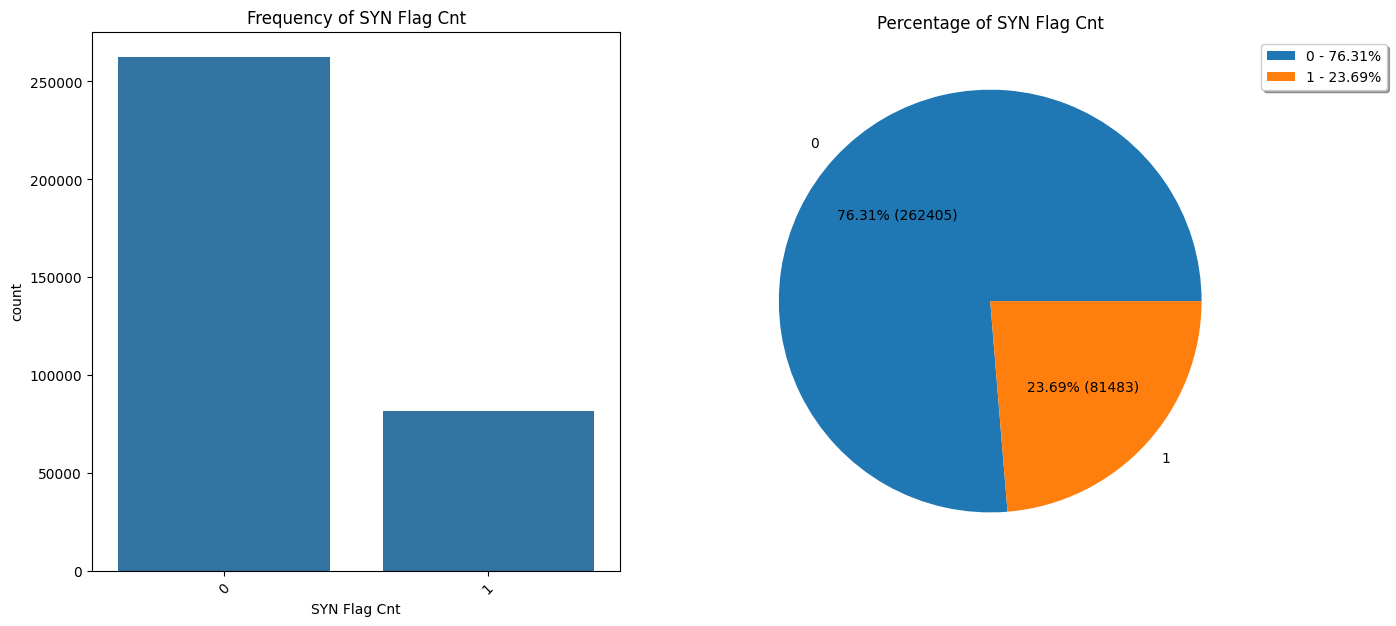

              RST Flag Cnt      Ratio
RST Flag Cnt                         
0                   343523  99.893861
1                      365   0.106139




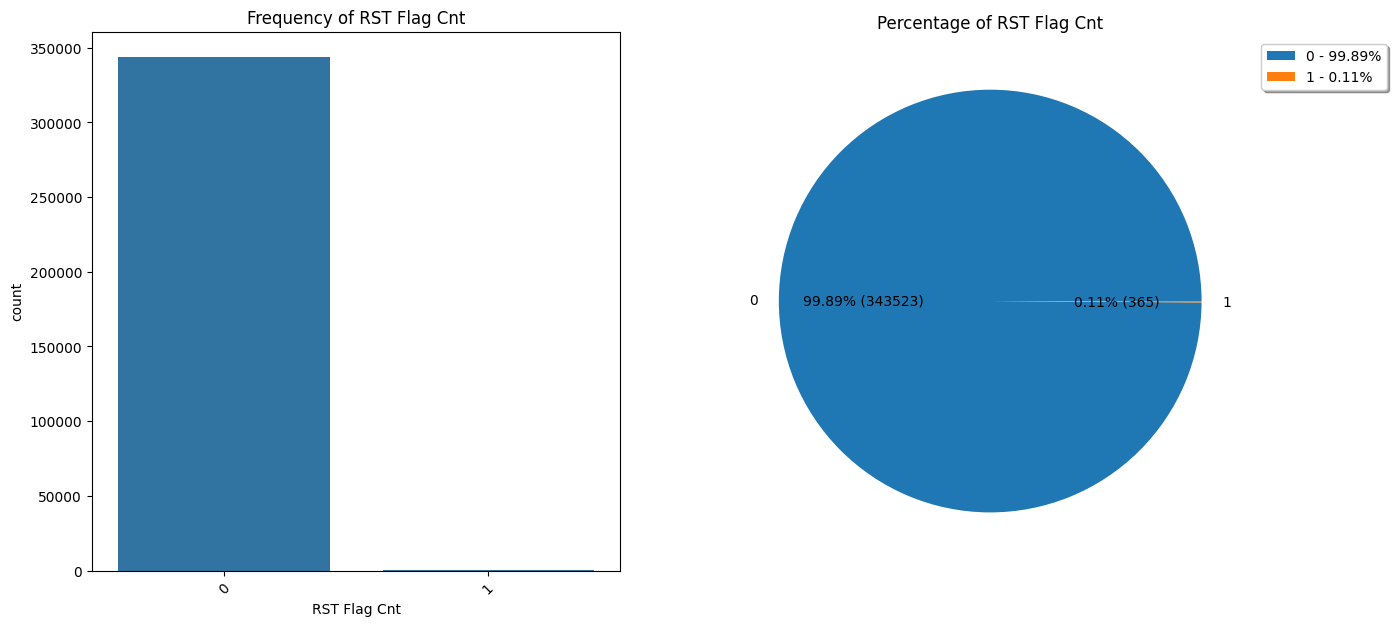

              PSH Flag Cnt      Ratio
PSH Flag Cnt                         
0                   325367  94.614235
1                    18521   5.385765




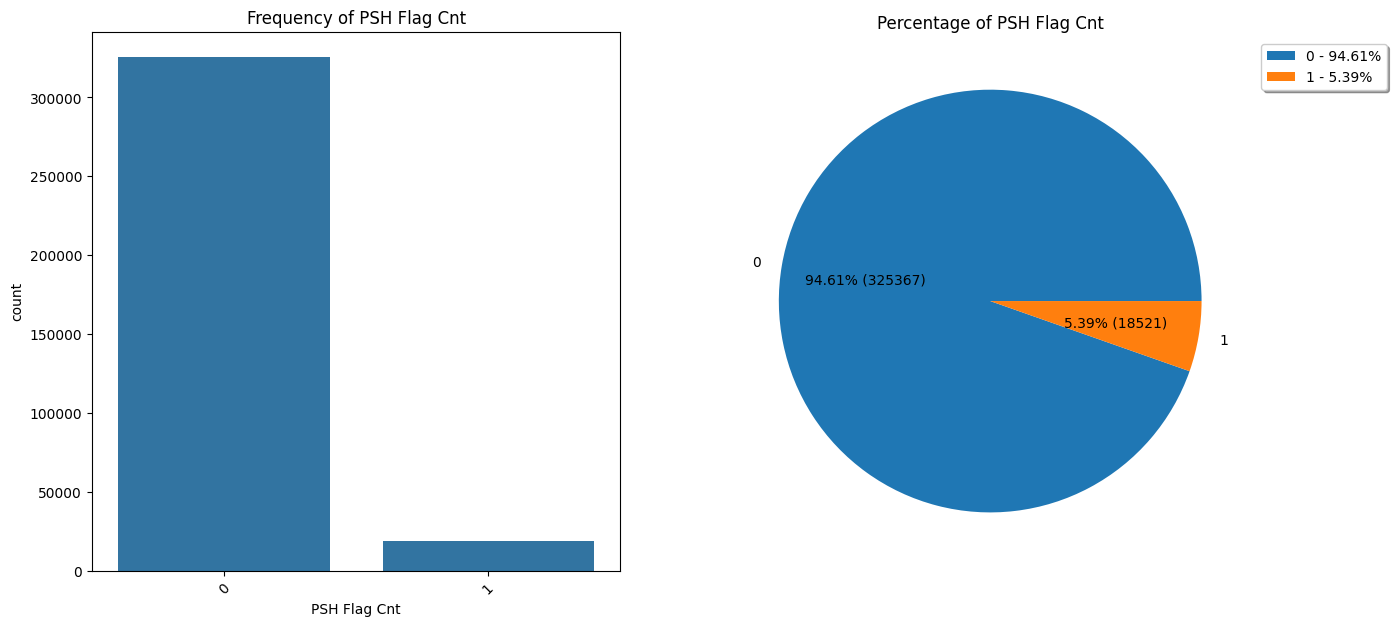

              ACK Flag Cnt      Ratio
ACK Flag Cnt                         
0                   249583  72.576827
1                    94305  27.423173




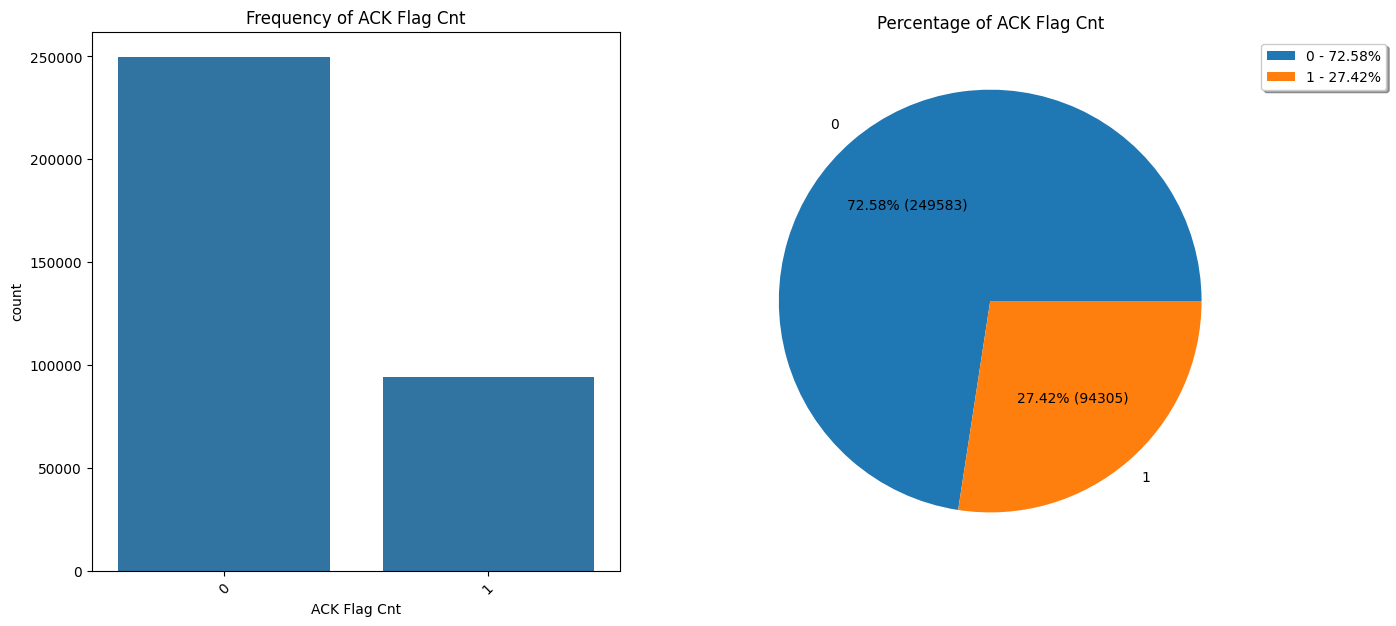

              URG Flag Cnt      Ratio
URG Flag Cnt                         
0                   339889  98.837121
1                     3999   1.162879




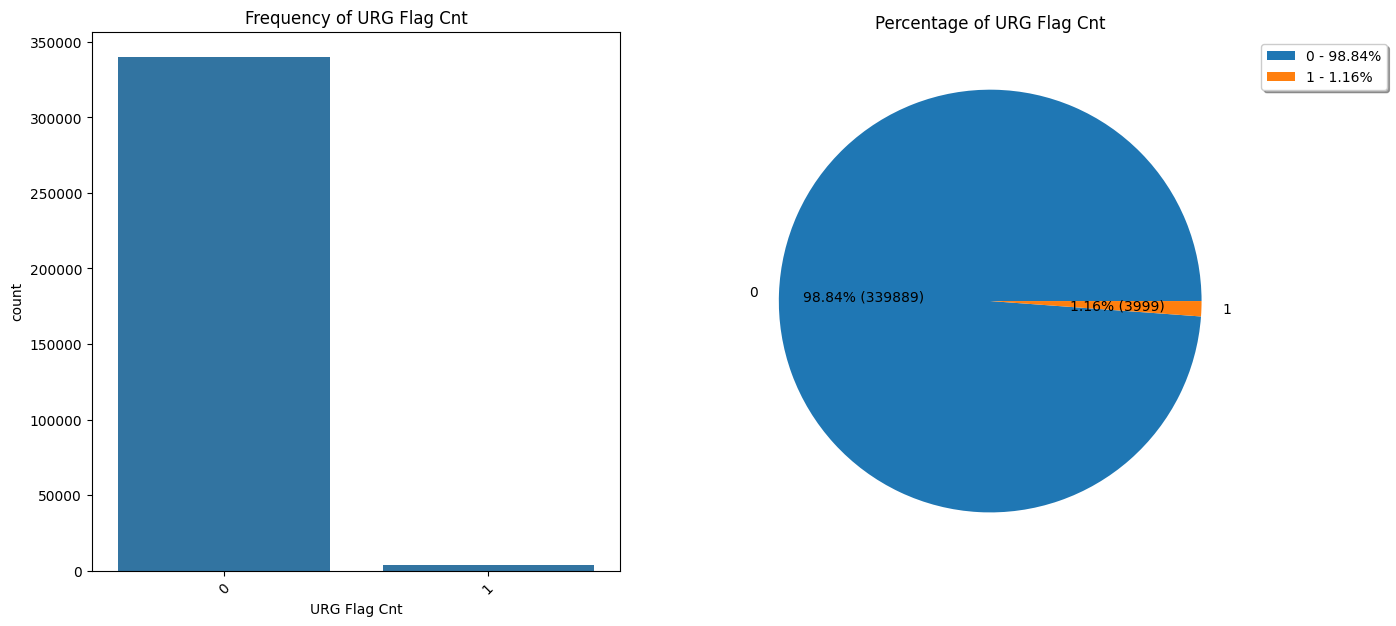

In [20]:
def cat_summary(data, col, plot=False):
    print(
        pd.DataFrame(
            {
                col: data[col].value_counts(),
                "Ratio": data[col].value_counts() / len(data) * 100,
            }
        )
    )
    print("\n")

    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(15, 7))
        plt.subplot(1, 2, 1)
        sns.countplot(x=col, data=data)
        plt.xticks(rotation=45)
        plt.title(f"Frequency of {col}")

        plt.subplot(1, 2, 2)
        values = data[col].value_counts()
        plt.pie(
            x=values,
            labels=values.index,
            autopct=lambda x: "{:.2f}% ({:.0f})".format(x, x / 100 * sum(values)),
        )
        plt.legend(
            labels=[
                "{} - {:.2f}%".format(index, value / sum(values) * 100)
                for index, value in zip(values.index, values)
            ],
            loc="upper left",
            bbox_to_anchor=(1, 1),
            fancybox=True,
            shadow=True,
            ncol=1,
        )
        plt.title(f"Percentage of {col}")
        plt.show(block=True)


for col in cat_cols:
    cat_summary(df, col, True)

# Numberical Columns

In [21]:
# Distribution Plots for Numerical Columns


def my_histplot(data, col, ax):
    sns.histplot(x=col, data=data, kde=True, ax=ax)
    ax.set_title(f"Histogram of {col}")


def my_distplot(data, col, ax):
    sns.distplot(data[col], ax=ax)
    ax.set_title(f"Distribution of {col}")


def my_kdeplot(data, col, ax):
    sns.kdeplot(x=col, data=data, ax=ax)
    ax.set_title(f"KDE Plot of {col}")


# Relational Plots for Numerical Columns


def my_scatterplot(data, col, ax):
    sns.scatterplot(x=col, data=data, ax=ax)
    ax.set_title(f"Scatter Plot of {col}")


def my_lineplot(data, col, ax):
    sns.lineplot(x=col, data=data, ax=ax)
    ax.set_title(f"Line Plot of {col}")


# Categorical Plots for Categorical Columns


def my_pie_chart(data, col, ax):
    values = data[col].value_counts()
    ax.pie(
        x=values,
        labels=values.index,
        autopct=lambda x: "{:.2f}% ({:.0f})".format(x, x / 100 * sum(values)),
    )
    ax.legend(
        labels=[
            "{} - {:.2f}%".format(index, value / sum(values) * 100)
            for index, value in zip(values.index, values)
        ],
        loc="upper left",
        bbox_to_anchor=(1, 1),
        fancybox=True,
        shadow=True,
        ncol=1,
    )
    ax.set_title(f"Pie Chart of {col}")


def my_countplot(data, col, ax):
    sns.countplot(x=col, data=data, ax=ax)
    ax.set_title(f"Count Plot of {col}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


def my_boxplot(data, col, ax):
    sns.boxplot(y=col, data=data, ax=ax)


def my_violinplot(data, col, ax):
    sns.violinplot(y=col, data=data, ax=ax)


def my_swarmplot(data, col, ax):
    sns.swarmplot(y=col, data=data, ax=ax)


# Matrix Plots for Numerical Columns
def my_headmap(data, size):
    if size:
        plt.figure(figsize=size)
    sns.heatmap(
        data.corr(), annot=True, fmt=".1f", cmap="Blues", annot_kws={"size": 12}
    )
    plt.title("Correlation Matrix")
    plt.show()


### Packet Size and Flow Duration Analysis

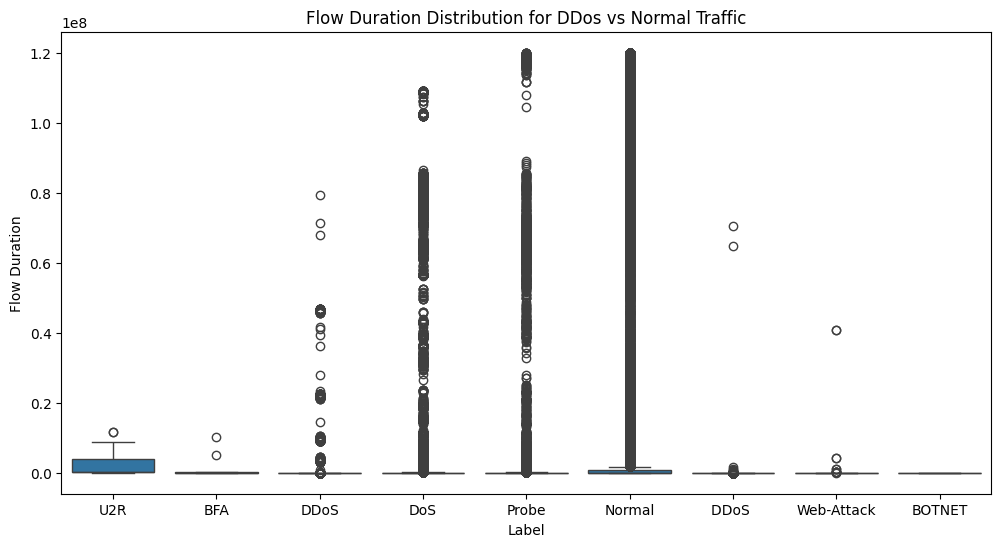

In [23]:
# Boxplot of Flow Duration by Attack Label
plt.figure(figsize=(12, 6))
sns.boxplot(x="Label", y="Flow Duration", data=df)
plt.title("Flow Duration Distribution for DDos vs Normal Traffic")
plt.show()

### Packet Flags and Attack Patterns

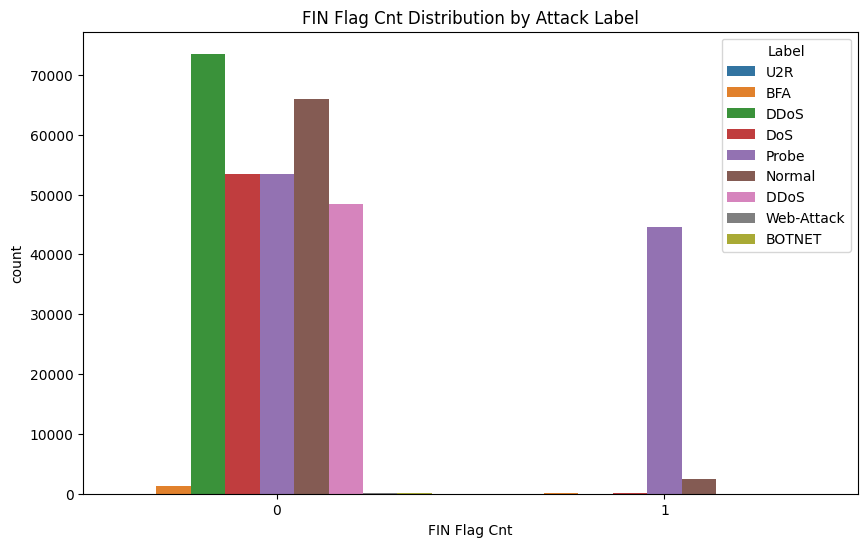

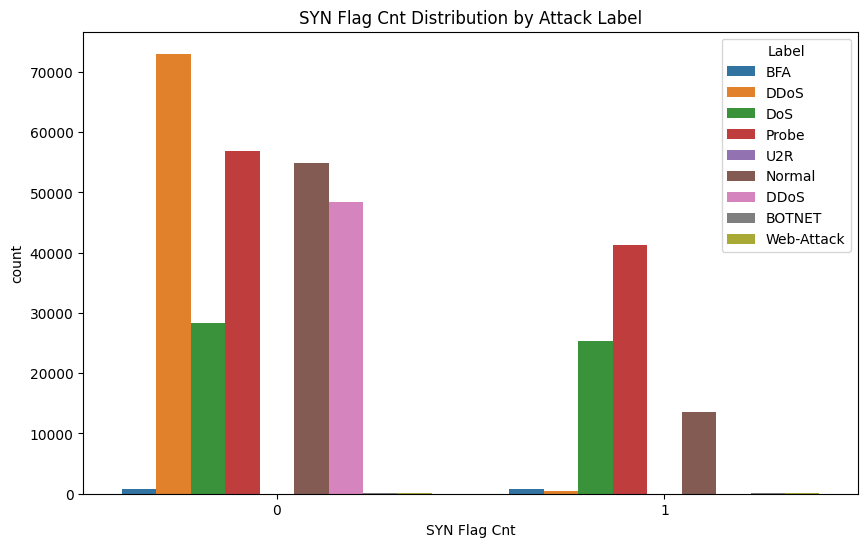

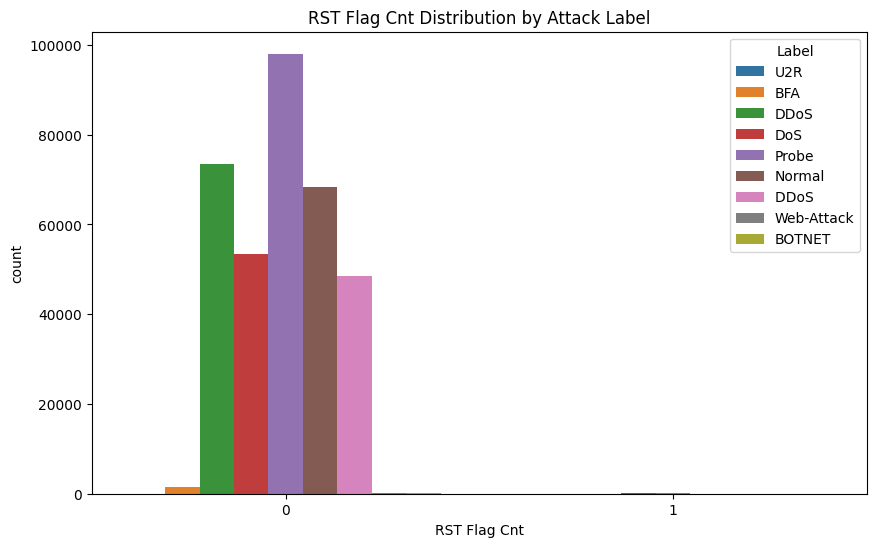

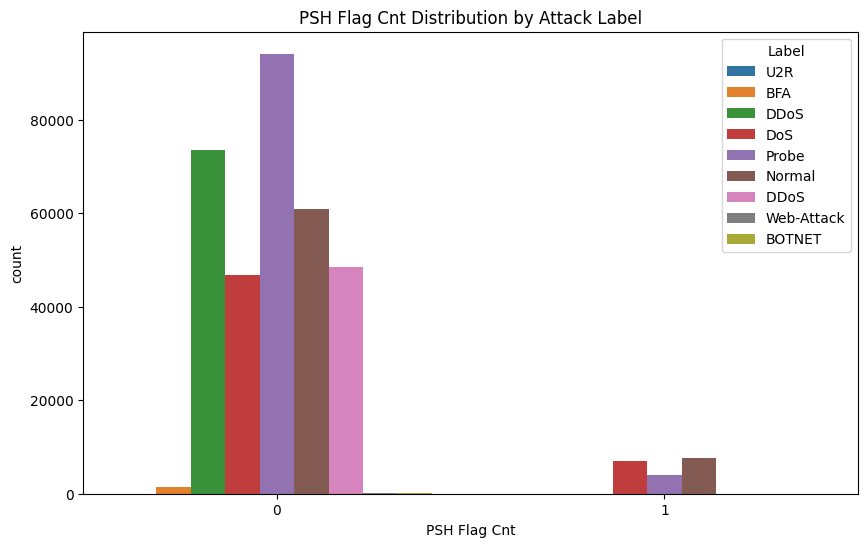

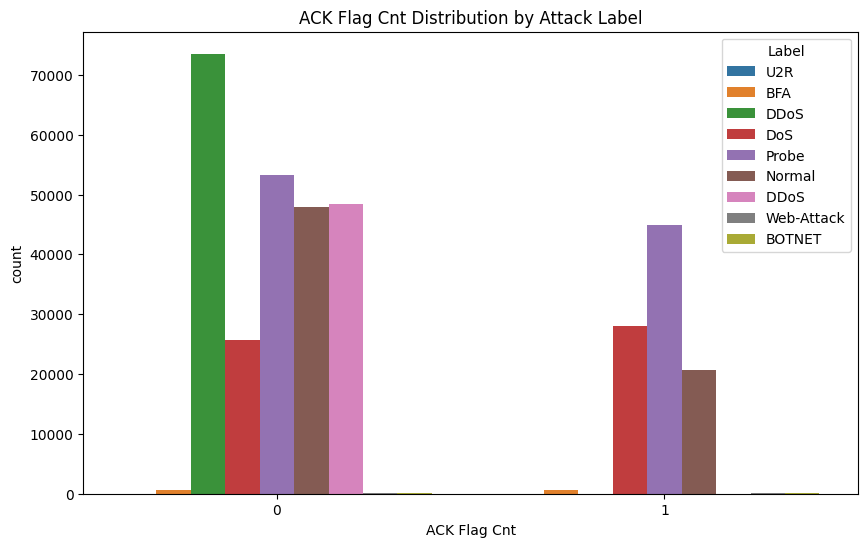

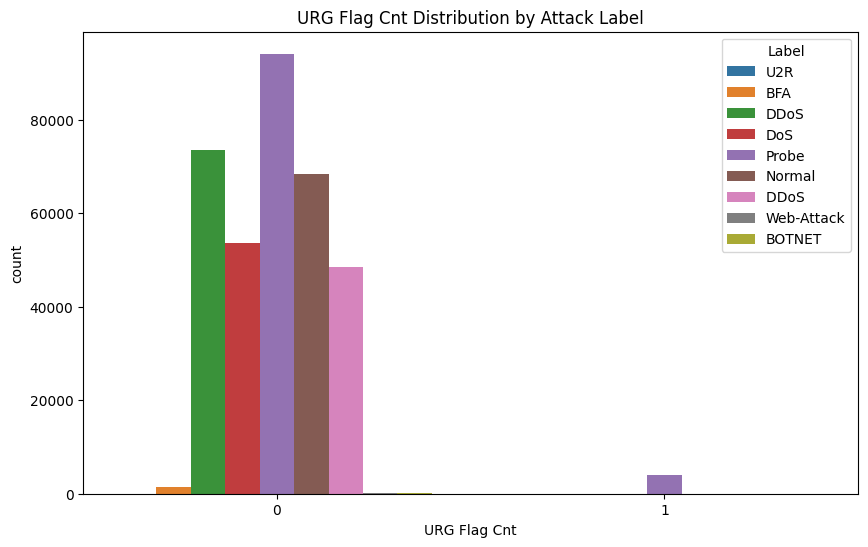

In [27]:
# Counting the number of occurrences of each flag in attack vs normal traffic

flag_cols = [col for col in df.columns if "Flag " in col]

for flag in flag_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=flag, hue="Label", data=df)
    plt.title(f"{flag} Distribution by Attack Label")
    plt.show()

### Requests from Different Protocols

Text(0.5, 1.0, 'The number of requests from different protocols')

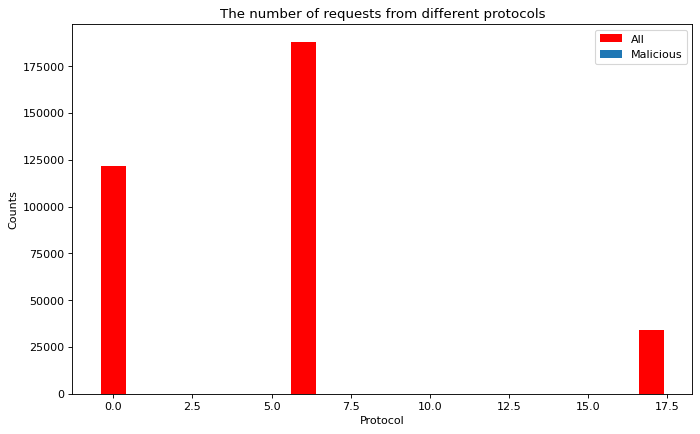

In [31]:
plt.figure(figsize=(10, 6), dpi=80)
plt.bar(
    list(dict(df["Protocol"].value_counts()).keys()),
    dict(df["Protocol"].value_counts()).values(),
    color="r",
)
plt.bar(
    list(dict(df[df["Label"] == 1]["Protocol"].value_counts()).keys()),
    dict(df[df["Label"] == 1]["Protocol"].value_counts()).values(),
    color="b",
)

plt.xlabel("Protocol")
plt.ylabel("Counts")
plt.legend(["All", "Malicious"])
plt.title("The number of requests from different protocols")

### Correlation Matrix

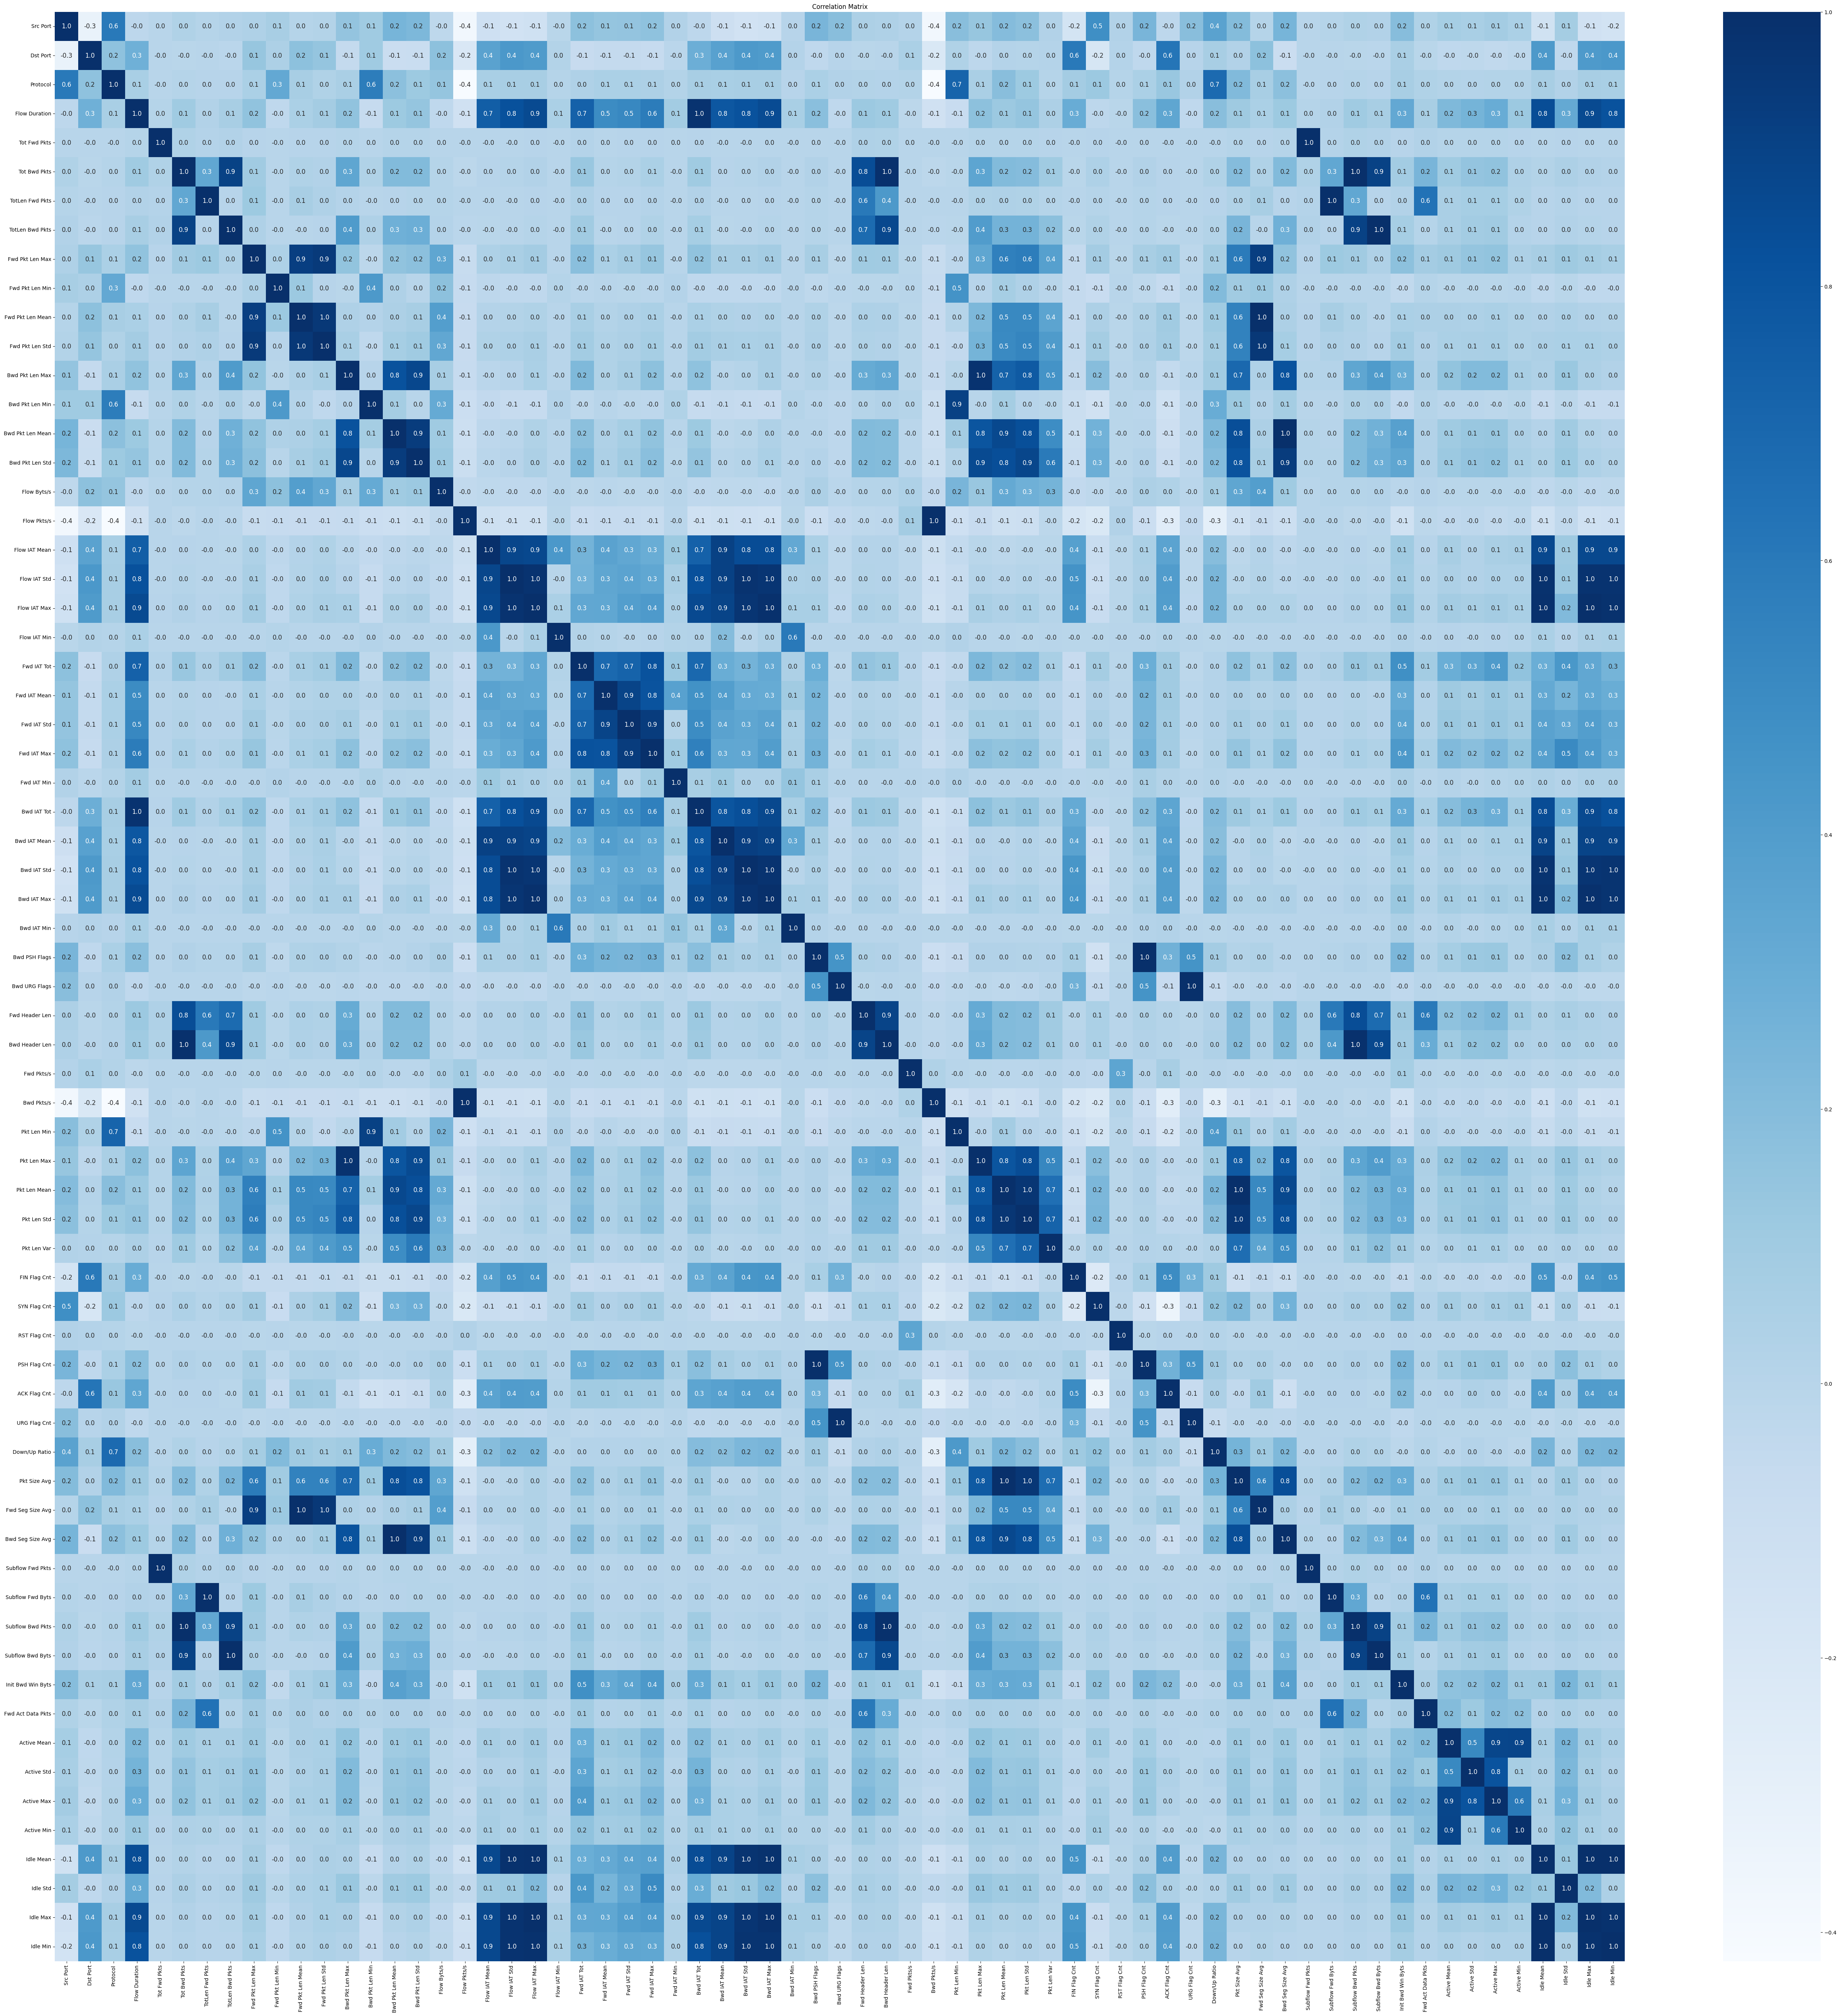

In [32]:
n_numeric_cols = len(df.select_dtypes(include=[np.number]).columns)
my_headmap(
    df.select_dtypes(include=[np.number]),
    size=(n_numeric_cols + 1, n_numeric_cols + 1),
)

## Future Engineering

### Feature Selection

In [33]:
# Select only numeric columns
numerical_df = df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr_matrix = numerical_df.corr().abs()

# Generate a boolean mask for the upper triangle
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)

# Select the upper triangle of the correlation matrix
upper_triangle = corr_matrix.where(mask)

# Find the columns with correlation of 0.8 or higher
high_corr_cols = [
    col for col in upper_triangle.columns if any(upper_triangle[col] > 0.8)
]

# Display the number of highly correlated columns and their names
print(f"Total number of highly correlated columns: {len(high_corr_cols)}")
print("Highly correlated columns are:", high_corr_cols)

Total number of highly correlated columns: 34
Highly correlated columns are: ['TotLen Bwd Pkts', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Fwd Header Len', 'Bwd Header Len', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'PSH Flag Cnt', 'URG Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Max', 'Idle Min']


In [34]:
# Remove highly correlated columns from the dataset
df.drop(high_corr_cols, axis=1, inplace=True)

In [35]:
# Shape of the dataset after removing highly correlated columns
df.shape

(343888, 38)

### Train Test Validation Split

In [35]:
X_train, X_val, y_train, y_val = train_test_split(
    train_df.drop("Label", axis=1), train_df["Label"], test_size=0.2, random_state=42
)
X_test, y_test = test_df.drop("Label", axis=1), test_df["Label"]

In [36]:
X_train.shape, X_val.shape, X_test.shape

((93496, 32), (23374, 32), (38922, 32))

In [37]:
y_train.shape, y_val.shape, y_test.shape

((93496,), (23374,), (38922,))

### Feature Encoding

In [38]:
# Encode the target variable

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

# Label mapping for the target variable
label_map = {index: Label for index, Label in enumerate(le.classes_)}

In [39]:
label_map

{0: 'Benign',
 1: 'LDAP',
 2: 'MSSQL',
 3: 'NetBIOS',
 4: 'Syn',
 5: 'UDP',
 6: 'UDPLag'}

### Feature Scaling

In [40]:
# Feature Scaling using MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## Model Training and Evaluation


Training Models:   0%|          | 0/5 [00:00<?, ?it/s]

Training Random Forest......


Training Models:  20%|██        | 1/5 [00:22<01:29, 22.47s/it]

Training KNN......


Training Models:  40%|████      | 2/5 [00:25<00:33, 11.19s/it]

Training Extra Trees......


Training Models:  60%|██████    | 3/5 [00:34<00:19,  9.87s/it]

Training MLP Classifier......


Training Models:  80%|████████  | 4/5 [01:23<00:25, 25.31s/it]

Training XGBoost......


Training Models: 100%|██████████| 5/5 [01:32<00:00, 18.51s/it]


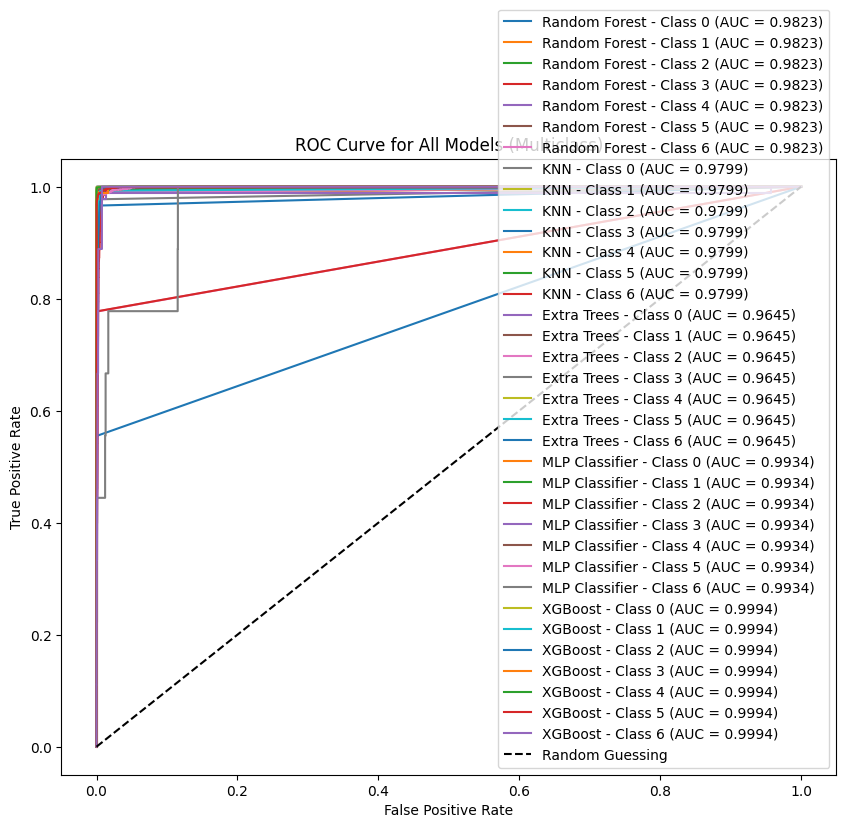

Testing Scores between different models:


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,CV Score
0,Random Forest,0.992641,0.992614,0.992641,0.992615,0.982262,0.992716
1,KNN,0.990160,0.990073,0.990160,0.990076,0.979937,0.990235
2,Extra Trees,0.992171,0.992046,0.992171,0.992080,0.964470,0.992556
3,MLP Classifier,0.988748,0.988698,0.988748,0.988657,0.993424,0.988524
4,XGBoost,0.992256,0.992407,0.992256,0.992310,0.999445,0.991540


In [ ]:
# Train and evaluate models
def train_model(X_train, X_test, y_train, y_test):
    # Initialize models
    classifiers = {
        "Random Forest": RandomForestClassifier(),
        "KNN": KNeighborsClassifier(n_neighbors=10),
        "Extra Trees": ExtraTreesClassifier(),
        "MLP Classifier": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000),
        "XGBoost": XGBClassifier(),
    }

    scores_list = []

    # Initialize plot for ROC curves
    plt.figure(figsize=(10, 8))

    # Train and evaluate models with progress bar
    for name, model in tqdm(classifiers.items(), desc="Training Models"):
        print(f"Training {name}......")

        # Train model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Evaluate predictions for multiclass
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average="weighted", zero_division=0)
        recall = recall_score(y_test, y_pred, average="weighted", zero_division=0)
        f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class="ovr")

        cv_score = np.mean(cross_val_score(model, X_train, y_train, cv=5))

        # ROC curve for the model (for each class)
        y_proba = model.predict_proba(X_test)
        for i in range(len(np.unique(y_train))):
            fpr, tpr, _ = roc_curve(y_test, y_proba[:, i], pos_label=i)
            plt.plot(fpr, tpr, label=f"{name} - Class {i} (AUC = {roc_auc:.4f})")

        # Append scores to the list
        scores_list.append(
            {
                "Model": name,
                "Accuracy": accuracy,
                "Precision": precision,
                "Recall": recall,
                "F1 Score": f1,
                "ROC AUC": roc_auc,
                "CV Score": cv_score,
            }
        )

    # Finalize the ROC plot
    plt.plot(
        [0, 1], [0, 1], "k--", label="Random Guessing"
    )  # Diagonal line for random guessing
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for All Models (Multiclass)")
    plt.legend(loc="lower right")
    plt.show()

    # Create and display the DataFrame of scores
    scores = pd.DataFrame(scores_list)
    return scores


# Run the function
scores = train_model(X_train, X_val, y_train, y_val)
print("Testing Scores between different models:")
display(scores.style.background_gradient(cmap="viridis"))

#### Display the Accuracy Score Plot

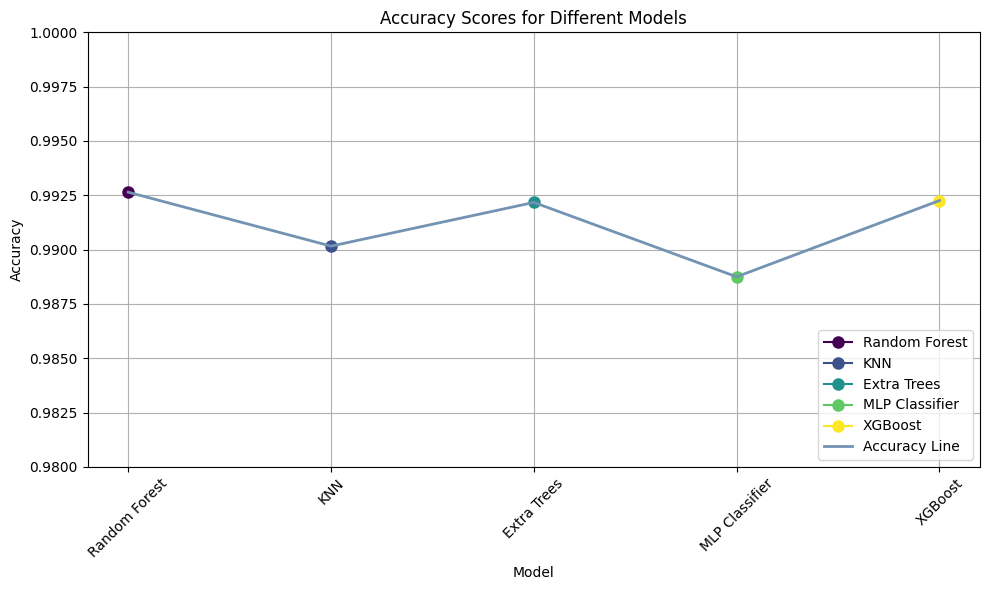

In [42]:
# Assuming 'scores' DataFrame has columns 'Model' and 'Accuracy'
models = scores["Model"]
accuracy = scores["Accuracy"]

# Generate a color map
colors = cm.viridis(np.linspace(0, 1, len(models)))

# Plotting the accuracy points with color for each model
plt.figure(figsize=(10, 6))
for i, (model, acc) in enumerate(zip(models, accuracy)):
    plt.plot(model, acc, marker="o", color=colors[i], markersize=8, label=model)

# Adding a line that passes through the points
plt.plot(
    models, accuracy, linestyle="-", color="#7393B3", linewidth=2, label="Accuracy Line"
)

# Customizing the plot
plt.title("Accuracy Scores for Different Models")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0.98, 1)
plt.xticks(rotation=45)
plt.grid(True)

# Display the plot with legend at the bottom right
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))  # Remove duplicate labels
plt.legend(unique_labels.values(), unique_labels.keys(), loc="lower right")

# Show the plot
plt.tight_layout()
plt.show()


### Export the Best Model (Random Forest) for Deployment


In [43]:
# Train the best model on the training data
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Save the model to a file using pickle
with open("random_forest_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)

print("Model saved as 'random_forest_model.pkl'")

Model saved as 'random_forest_model.pkl'


### Recommendation
- **Random Forest** is the best choice for DDoS prediction due to its balanced performance across all metrics.
- **MLP Classifier** can be considered for scenarios prioritizing the ability to distinguish between DDoS and non-DDoS traffic (as indicated by the ROC AUC score).